# Visualizing and Evaluating Forests of Uncertaint(r)ees
This notebook is a collection of visualizations and evaluation steps designed to help you better understand the approach and the results of our contribution to the 2023/24 ViEWS prediction challenge.


### Setup checks
Check working directory and set font for figures.

In [1]:
import os
print(os.getcwd())
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Crimson Pro'] + plt.rcParams['font.serif']

/home/daniel/uncertaintrees


## Clustering for local models
Below is a visualization of the different steps taken to generate clusters for our local models generated with the help of a version of our clustering function modified to be able to output intermediate steps.

### Setup


In [2]:
from datetime import date

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely import MultiPoint, Point, box
from shapely.constructive import concave_hull
from shapely.ops import nearest_points
from sklearn.cluster import HDBSCAN

from src.utils.conversion import get_month_id, pgid_to_latlon
from src.utils.data_prep import read_prio_training_data


# slightly modified version of the clustering function used to create and output the steps in between for visualization
def make_clusters_hdbscan(df: pd.DataFrame, min_months: int, cluster_kwargs: dict,
                          step:int =None) -> pd.DataFrame:
    def cluster_polys(ratio=0.5):
        polys = []
        ls = []
        for label in set(labels):
            # Skip noise clusters
            if label == -1:
                continue
            else:
                mask = labels == label  # Get all points belonging to the existing cluster
                # poly = MultiPoint(points[mask]).convex_hull
                polys.append(concave_hull(MultiPoint(points_violence[mask]), ratio=ratio))
                ls.append(label)
        gdf_polys = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), data=pd.Series(ls, name='index')).set_index('index')
        return gdf_polys

    def assign_zeros_to_clusters():
        # Now, create a distance matrix measuring the shortest distance of every point outside of the polygons
        # to the polygon borders.

        # Select all points that are not inside any cluster
        # That is basically all points with the target variable equal to 0 and all points with a label of -1
        coords = np.concatenate(
            (clust_df[clust_df['ged_sb'] == 0][['lon', 'lat']].to_numpy(), points_violence[labels == -1]))
        pgids = np.concatenate((clust_df[clust_df['ged_sb'] == 0].index.to_numpy(), pgids_violence[labels == -1]))
        for pgid, coord in zip(pgids, coords):
            point = Point(coord)
            min_distance = float('inf')  # Initialize with a very large value
            for cluster, poly in gdf_polys.geometry.items():
                nearest = nearest_points(poly.boundary, point)[0]  # Get the nearest point on the polygon's boundary
                distance = point.distance(nearest)  # Calculate the distance between the point and the nearest point
                if distance < min_distance:
                    min_distance = distance
                    clust_df.at[pgid, 'cluster'] = cluster
        return

    ## Identify pgids with fatalities and create clust_df
    clust_df = df.loc[:get_month_id(date(2017, 10, 31)), :].groupby('priogrid_gid')['ged_sb'].sum().to_frame()
    lat, lon = np.vectorize(pgid_to_latlon)(clust_df.index.to_list())
    clust_df = clust_df.assign(lat=lat, lon=lon)

    points_violence = clust_df[clust_df['ged_sb'] > 0][['lon', 'lat']].to_numpy()
    temp = (df.loc[:get_month_id(date(2017, 10, 31)), :]['ged_sb'] != 0).groupby('priogrid_gid').sum()
    weights = temp.loc[clust_df[clust_df['ged_sb'] > 0].index].values
    pgids_violence = clust_df[clust_df['ged_sb'] > 0].index.to_numpy()

    # manually tuned clusters for coverage of most visible cluster so there is something to assign to
    cluster = HDBSCAN(**cluster_kwargs).fit(points_violence)
    labels = cluster.labels_

    gdf_polys = cluster_polys()

    if step == 1:
        # setup lookup dict and add cluster info to clust_df
        cluster_assignments = dict.fromkeys(clust_df.index)
        for idx, label in enumerate(labels):
            cluster_assignments[pgids_violence[idx]] = label
        clust_df['cluster'] = pd.Series(cluster_assignments)
        print('return step', step)
        return clust_df, gdf_polys

    # calculate closest polygons for each based on centroids (this means smaller clusters are closer to each other)
    dist = []
    for poly in gdf_polys.geometry:
        distances = np.array(gdf_polys.centroid.distance(poly.centroid).sort_values().index[1:])
        dist.append(distances)
    gdf_polys['distances'] = dist

    # merge clusters which cover less than the specified minimum number of priogrid months to neighboring
    problem_groups = [c for c in np.unique(labels)[1:] if weights[labels == c].sum() < min_months]
    for c in problem_groups:
        mask = labels == c
        if weights[mask].sum() > min_months:
            continue
        labels[mask] = gdf_polys.loc[c].distances[0]

    # clean up clusters
    replace_map = {val: idx-1 for idx, val in enumerate(np.unique(labels))}
    labels = np.vectorize(lambda x: replace_map[x])(labels)

    # setup lookup dict and add cluster info to clust_df
    cluster_assignments = dict.fromkeys(clust_df.index)
    for idx, label in enumerate(labels):
        cluster_assignments[pgids_violence[idx]] = label
    clust_df['cluster'] = pd.Series(cluster_assignments)

    # re-calculate polygons based on merged clusters before assigning non-assigned grids
    gdf_polys = cluster_polys()
    if step == 2 :
        print('return step', step)
        return clust_df, gdf_polys

    assign_zeros_to_clusters()

    clust_df['cluster'] = clust_df['cluster'].astype(int)

    if step == 3:
        print('return step', step)
        return clust_df, gdf_polys

    return clust_df

### Visualization
Figure 1

return step 1
return step 2
return step 3


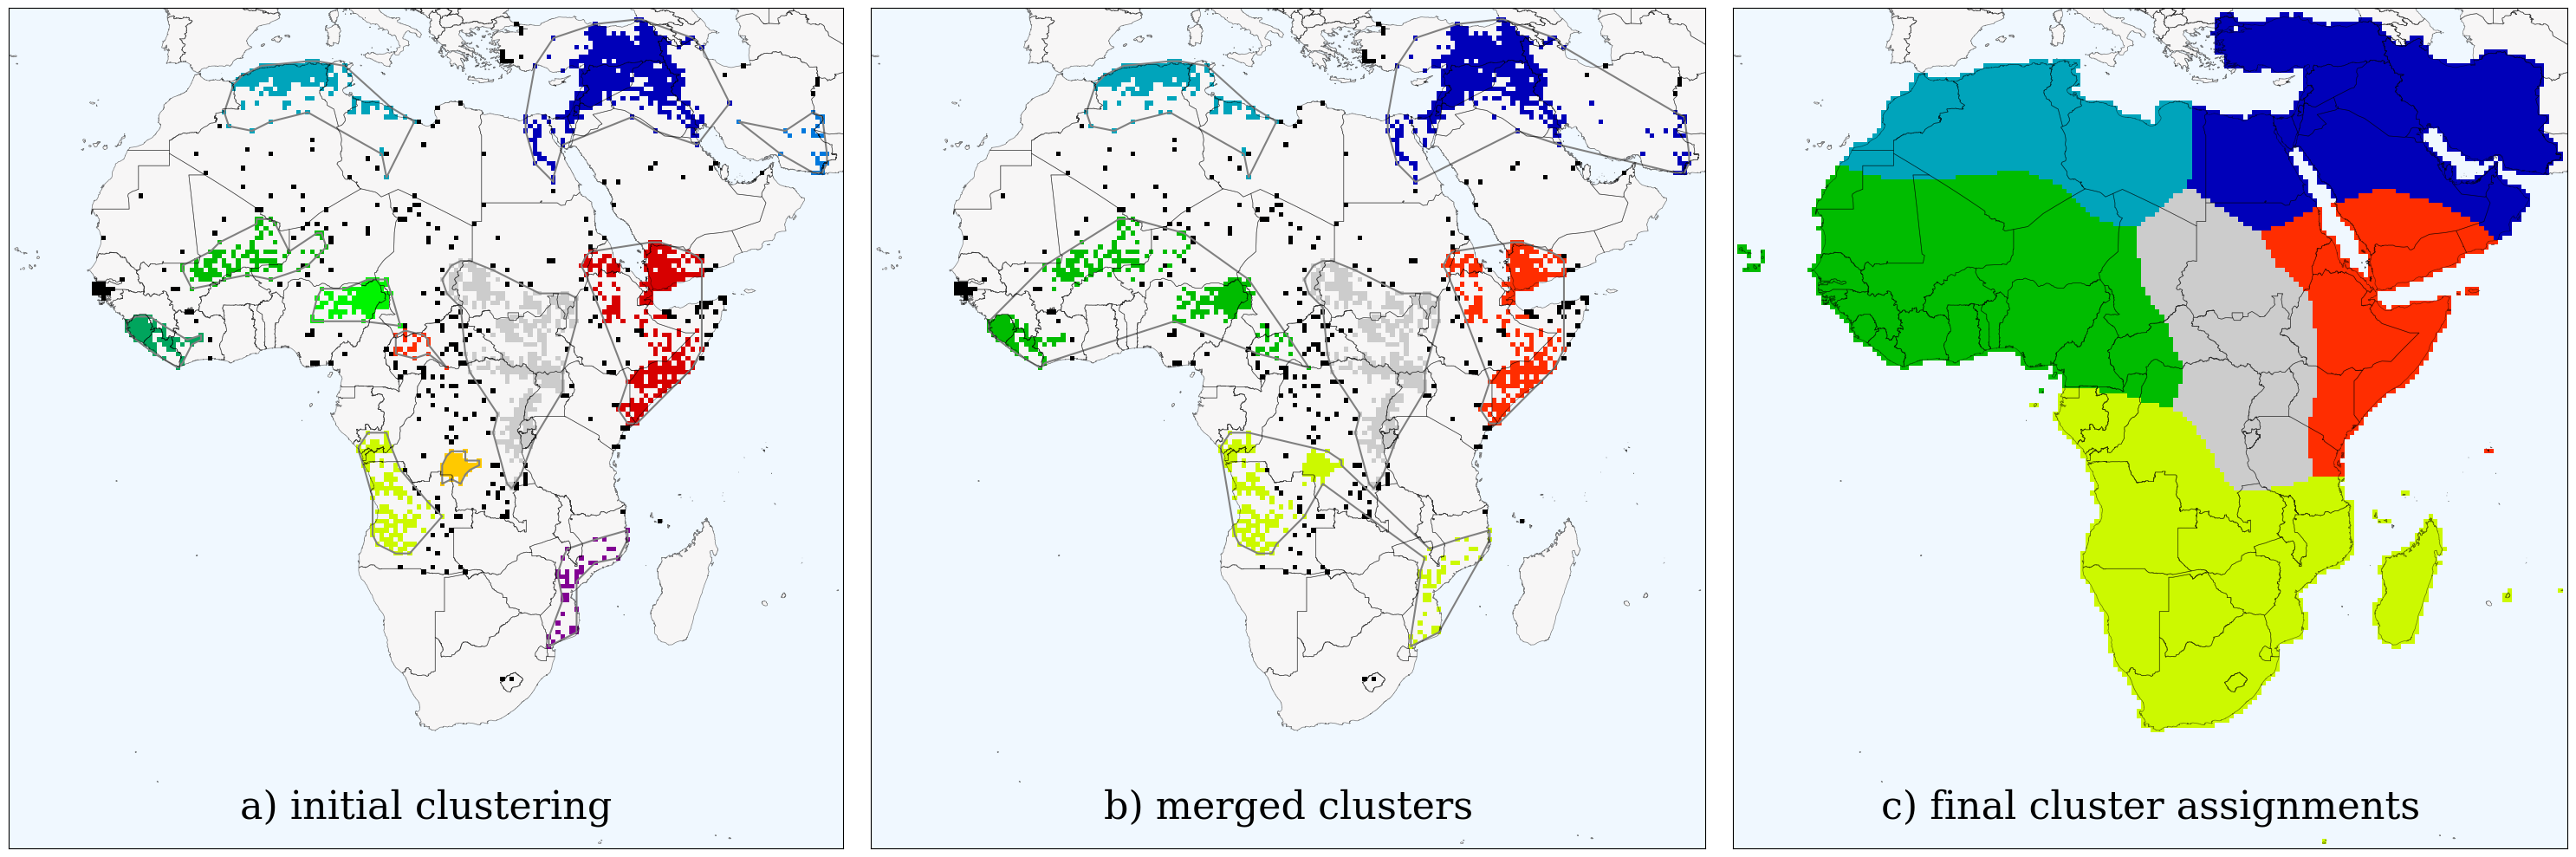

In [3]:
fp_views = 'data/views_data/' # path to views data
df_train, _ = read_prio_training_data(fp_views)
min_months = 1000
cluster_kwargs = {'min_cluster_size': 18, 'min_samples': 15, 'cluster_selection_epsilon': 2.2}

# generate the different steps in between
clust_df1, gdf_polys1 = make_clusters_hdbscan(df_train, min_months, cluster_kwargs, step=1)
clust_df2, gdf_polys2 = make_clusters_hdbscan(df_train, min_months, cluster_kwargs, step=2)
clust_df3, gdf_polys3 = make_clusters_hdbscan(df_train, min_months, cluster_kwargs, step=3)

# plotting
countries = gpd.read_file('data/geoBoundariesCGAZ_ADM0.gpkg', crs='4326')
clust_gdf3 = clust_df3.copy()
clust_gdf3['coords'] = list(clust_gdf3.reset_index().priogrid_gid.apply(pgid_to_latlon))
clust_gdf3['geometry'] = clust_gdf3.coords.apply(lambda x: box(x[1] - .25, x[0] - .25, x[1] + .25, x[0] + .25))
clust_gdf3 = gpd.GeoDataFrame(clust_gdf3, geometry=clust_gdf3.geometry)
views_bounds = clust_gdf3.total_bounds

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for ax in axs:
    countries.plot(facecolor='seashell', edgecolor='None', ax=ax, linewidth=0.5, alpha=0.5)

clust_df1.set_index(['lat', 'lon'])['cluster'].to_xarray().plot(ax=axs[0], cmap='nipy_spectral',
                                                               vmin=clust_df1['cluster'].min(),
                                                               vmax=clust_df1['cluster'].max(),
                                                               add_colorbar=False, add_labels=False)
gdf_polys1.plot(ax=axs[0], facecolor='None', edgecolor='gray', linewidth=1.5)

clust_df2.set_index(['lat', 'lon'])['cluster'].to_xarray().plot(ax=axs[1], cmap='nipy_spectral',
                                                                vmin=clust_df2['cluster'].min(),
                                                                vmax=clust_df2['cluster'].max(),
                                                                add_colorbar=False, add_labels=False)

gdf_polys2.plot(ax=axs[1], facecolor='None', edgecolor='gray', linewidth=1.5)

clust_gdf3.plot(column='cluster', ax=axs[2], cmap='nipy_spectral', vmin=clust_df2['cluster'].min(),
                vmax=clust_df2['cluster'].max(), legend=False)

labels = ["a) initial clustering", "b) merged clusters", "c) final cluster assignments"]
for i, ax in enumerate(axs):
    countries.plot(facecolor='None', edgecolor='black', ax=ax, linewidth=0.5, alpha=0.5)
    ax.set_xlim(views_bounds[0]-.5, views_bounds[2]+.5)
    ax.set_ylim(views_bounds[1]-.5, views_bounds[3]+.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(labels[i], size=32, labelpad=-50)
    ax.set_facecolor("aliceblue")
plt.tight_layout()
plt.savefig('figures/Figure_1_local_clustering.png', dpi=300)
plt.show()

## Auto-ML model selection per timestep and cluster

The different available models are selected based on tuning performance, but which model was selected how often?

### Setup

Below is simply the copy-pasted tuning config, which consists mainly of the hyperparameter spaces, for our tuning and prediction pipeline. The HurdleStepsWithTuning class can output the best tuned model but wasn't setup to only read the data, so the corresponding config is required.

In [7]:
from functools import partial
from hyperopt import hp
from sklearn.metrics import make_scorer, average_precision_score
from src.utils.scoring import drf_predict, qrf_predict, ngb_predict, crps_scorer

# these wrappers handle custom kwargs/options for predictors to get consistent output
prediction_wrappers = {
    'DRF': drf_predict,
    'QRF': qrf_predict,
    'NGB': ngb_predict,
}

# we use precision recall by default for classifier tuning
scorer_clf = {
    'RF': make_scorer(average_precision_score, response_method='predict_proba'),
    'XGB': make_scorer(average_precision_score, response_method='predict_proba'),
}

# freeze the estimator-specific prediction function in the general scorer function
scorer_reg = {key: partial(crps_scorer, func=item) for key, item in prediction_wrappers.items()}

# implementation is based on this structure (model_type: {space: {}, max_evals: int})
tuning_space_clf = {
    'RF': {
        'space': {
            'max_depth': hp.uniformint(label='max_depth', low=3, high=8),
            'n_estimators': hp.quniform(label='n_estimators', low=40, high=1000, q=20)
        },
        'max_evals': 30
    },
    'XGB': {
        'space': {
            'max_depth': hp.uniformint(label='max_depth', low=3, high=20, q=1),
            'n_estimators': hp.uniformint(label='n_estimators', low=40, high=1001, q=50),
            'learning_rate': hp.choice(label='learning_rate', options=[.001, .005, .01, .05, .1, .3]),  # important
            'gamma': hp.uniform(label='gamma', low=1, high=9),  # less important
            'subsample': hp.quniform(label='subsample', low=0.5, high=1.0, q=0.1),
            'colsample_bytree': hp.quniform(label='colsample_bytree', low=0.5, high=1, q=0.1),  # less important
            'reg_alpha': hp.uniformint(label='reg_alpha', low=0, high=100, q=1),  # less important
            'reg_lambda': hp.uniform(label='reg_lambda', low=0, high=1),  # less important
            'min_child_weight': hp.loguniform(label='min_child_weight', low=-3, high=2.75),  # important
            'max_delta_step': hp.uniform(label='max_delta_step', low=1, high=10)
        },
        'max_evals': 100
    },
}

tuning_space_reg = {
    'DRF': {
        'space': {
            'num_features': hp.uniformint(label='num_features', low=5, high=50, q=1),
            'num_trees': hp.quniform(label='num_trees', low=40, high=1000, q=20),
            'min_node_size': hp.uniformint(label='min_node_size', low=5, high=20, q=1),
            'alpha': hp.quniform(label='alpha', low=.01, high=.2, q=.01),  # less important
        },
        'max_evals': 50
    },
    'QRF': {
        'space': {
            'n_estimators': hp.quniform(label='n_estimators', low=160, high=1000, q=20), # fairly important
            'max_depth': hp.uniformint(label='max_depth', low=3, high=6), # important
            'criterion': hp.choice(label='criterion', options=['absolute_error']), # apparently not as good: ['squared_error', 'friedman_mse', 'poisson']
            'min_samples_split': hp.uniformint(label='min_samples_split', low=5, high=20, q=1), # less important
            'min_samples_leaf': hp.uniformint(label='min_samples_leaf', low=10, high=40, q=1),
            'max_features': hp.choice(label='max_features', options=['log2']), # ['sqrt', None] seem worse
        },
        'max_evals': 50
    },
    'NGB': {
        'space': {
            'n_estimators': hp.quniform(label='n_estimators', low=200, high=500, q=20),
            'learning_rate': hp.choice(label='learning_rate', options=[.001, .005, .01]),
            'base_criterion': hp.choice(label='base_criterion', options=['squared_error', 'friedman_mse']), # not important, both better than 'absolute_error'
            'base_splitter': hp.choice(label='base_splitter', options=['random']), # 'random' apparently better than 'best'
            'base_max_depth': hp.uniformint(label='base_max_depth', low=2, high=4),
            'minibatch_frac': hp.quniform(label='minibatch_frac', low=0.1, high=1, q=.1),
            'col_sample': hp.quniform(label='col_sample', low=0.1, high=1, q=.1),
        },
        'max_evals': 50
    },
}

hurdle_kwargs = {
    'scorer_clf': scorer_clf,
    'scorer_reg': scorer_reg,
    'tuning_space_clf': tuning_space_clf,
    'tuning_space_reg': tuning_space_reg,
    'prediction_wrappers': prediction_wrappers,
}

Loads selections from existing tuning results.

In [8]:
from contextlib import redirect_stdout
import pickle
from warnings import catch_warnings, simplefilter

import pandas as pd
from tqdm import tqdm
from src.estimators.hurdle import HurdleStepsWithTuning
from src.utils.data_prep import read_prio_training_data

fp_tuning = 'modelling/tuning_trials_hdbscan/'
fp_views = 'data/views_data'

def create_model_selection_df(fp_views:str, clusters:str, hurdle_kwargs:dict):
    df_train, model_dict = read_prio_training_data(fp_views)
    with open('data/clusters_dict.pkl', 'rb') as f:
        df_clusters = pickle.load(f)[clusters]
    targets = model_dict['targets_reg']
    features = model_dict['features']
    timesteps = [t[t.rfind('_') + 1:] for t in targets]
    cluster_list = sorted(df_clusters.cluster.unique())
    index = pd.MultiIndex.from_product([timesteps, ['global']+cluster_list], names=['timestep', 'cluster'])
    df_model_selection = pd.DataFrame(index=index, columns=['classification', 'regression'])
    for t in tqdm(targets):
        timestep = t[t.rfind('_') + 1:]
        # suppress prints designed as progress reports during tuning
        with open(os.devnull, "w") as f, redirect_stdout(f):
            global_hurdle = HurdleStepsWithTuning(**hurdle_kwargs, fp_tuning=fp_tuning)
            global_hurdle.tune(df_train, features=features, target=t)
        df_model_selection.loc[(timestep, 'global'), 'classification'] = global_hurdle.clf_model_type
        df_model_selection.loc[(timestep, 'global'), 'regression'] = global_hurdle.reg_model_type
        for c in cluster_list:
            # suppress prints designed as progress reports during tuning
            with open(os.devnull, "w") as f, redirect_stdout(f):
                local_hurdle = HurdleStepsWithTuning(**hurdle_kwargs, fp_tuning=fp_tuning)
                local_hurdle.tune(df_train, features=features, target=t, local_model=True, cluster=c)
            df_model_selection.loc[(timestep, c), 'classification'] = local_hurdle.clf_model_type
            df_model_selection.loc[(timestep, c), 'regression'] = local_hurdle.reg_model_type
    return df_model_selection

with catch_warnings():
    simplefilter("ignore")
    df_model_selection = create_model_selection_df(fp_views, 'hdbscan', hurdle_kwargs)


100%|██████████| 12/12 [00:28<00:00,  2.36s/it]


### Selections
For classifiers, RF is chosen in all global models, while XGB is favored for most local models
For regressors, NGB performed best during tuning, being chosen in 75% of global models and 80% of local models.

In [6]:
df_model_selection

classification regression
timestep cluster                          
t3       global              RF        QRF
         0                   RF        NGB
         1                  XGB        NGB
         2                  XGB        NGB
         3                  XGB        NGB
...                         ...        ...
t14      1                  XGB        NGB
         2                  XGB        NGB
         3                  XGB        NGB
         4                  XGB        QRF
         5                  XGB        NGB

[84 rows x 2 columns]

## Hurdle Assumption
Correlate classification target with regression target to get an indication as to the validity of the hurdle assumption.

In [2]:
from datetime import date
import pandas as pd
from src.utils.data_prep import read_prio_training_data
from src.utils.conversion import get_month_id

fp_views = 'data/views_data/'
fp_metrics = f'evaluation/metrics'
years = list(range(1990, 2017)) # stop 2017 because this is not a full year and this messes up the aggregation
actuals = read_prio_training_data(fp_views)[0][["ged_sb"]]

df_means_yearly = pd.DataFrame(index=pd.Index(years, name='window'), columns=['fat_count', 'dummy_count'])
df_means_monthly = pd.DataFrame(index=pd.Index(list(range(1,13)), name='month'), columns=['fat_count', 'dummy_count'], data=0)
for year in years:
    min_id = get_month_id(date(year, 1, 1))
    max_id = get_month_id(date(year, 12, 1))
    actuals_year = actuals.loc[min_id:max_id]
    # Trends in metrics correlate with mean fatalities/number of
    df_means_yearly.at[year, 'fat_count'] = actuals_year.ged_sb.sum()
    df_means_yearly.at[year, 'dummy_count'] = (actuals_year.ged_sb > 0).sum()

    # let see it that holds for months in general as well
    for month in range(12):
        month_id = min_id + month
        df_means_monthly.at[month + 1, 'fat_count'] += actuals_year.loc[month_id, 'ged_sb'].sum()
        df_means_monthly.at[month + 1, 'dummy_count'] += (actuals_year.ged_sb > 0).loc[month_id].sum()

correlation_years = df_means_yearly.corr().iloc[1,0]
correlation_months = df_means_monthly.corr().iloc[1,0]
print("Occurrence dummy vs. Fatalities - correlation across years:", correlation_years)
print("Occurrence dummy vs. Fatalities - correlation across years:", correlation_months)



Occurrence dummy vs. Fatalities - correlation across years: 0.6365988982996553
Occurrence dummy vs. Fatalities - correlation across years: 0.2014429332929621


Correlation is low to medium, which could be interpreted as support for the assumption of different underlying distributions. 

# Model Evaluation

## Individual Predictions

Lets examine some individual predictions, at low and high observed violence, both where the model performed well and where it did not.

### Setup

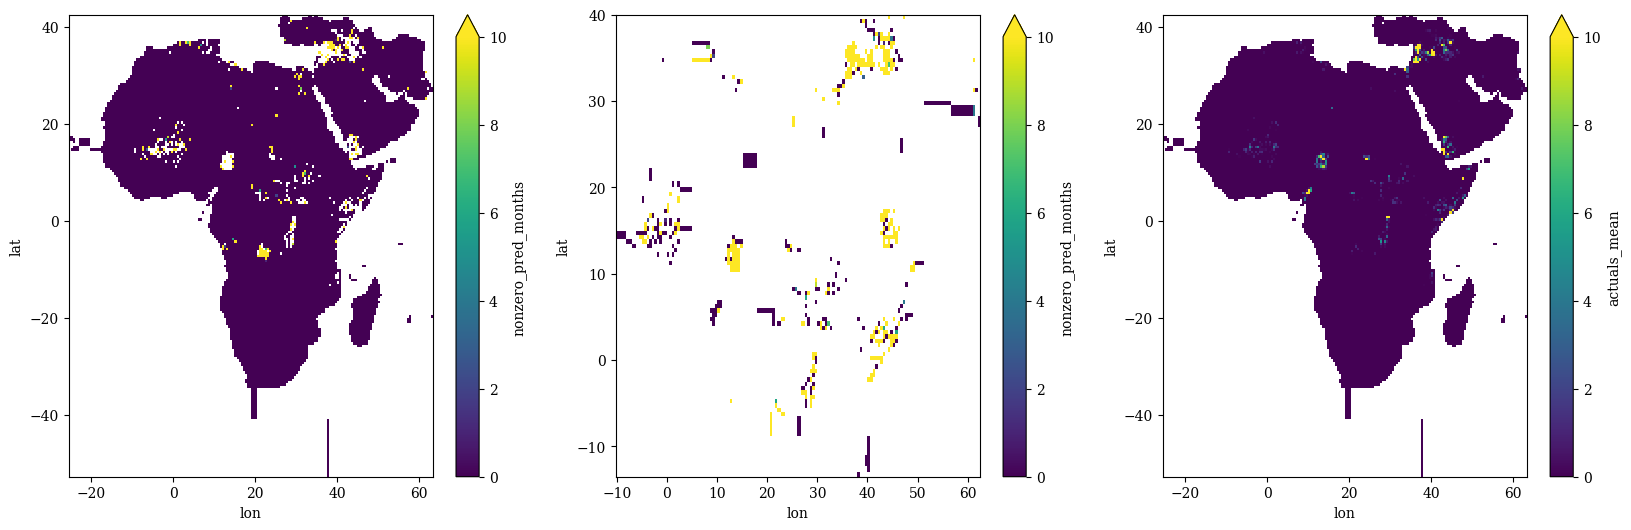

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import xarray as xr

from src.utils.data_prep import read_predictions, read_prio_actuals
from src.utils.conversion import pgid_to_latlon

def local_map_estimates(pgid):
    kde_peaks = []
    for month in np.arange(0, 12, 1):
        draws = predictions.sel(priogrid_gid=pgid).isel(month_id=month)
        kde = gaussian_kde(draws)
        possible_vals = np.arange(draws.min(), draws.max()+1, 1)
        density_values = kde(possible_vals)
        peak = possible_vals[np.argmax(density_values)]
        kde_peaks.append(peak)
    return kde_peaks

def plot_fats_cis(pgid, ax, exclude:list[str]=None):
    months = np.arange(1, 13, 1)
    fats = actuals.sel(priogrid_gid=pgid)
    quantiles = predictions.sel(priogrid_gid=pgid).quantile([0, .005, .025, .05, .175, .25, .375, .45, .55, .625, .75, .875, .95, .975, .995, 1], dim="draw")
    qalpha = 0.6
    ci_specs = [
        (0, 1, "palegoldenrod", "Sample min/max"),
        (0.005, 0.995, "yellow", "99% Prediction Interval"),
        (0.025, 0.975, "gold", "95% Prediction Interval"),
        (0.05, 0.95, "orange", "90% Prediction Interval"),
        (0.175, 0.875, "orangered", "75% Prediction Interval"),
        (0.25, 0.75, "red", "50% Prediction Interval"),
        (0.375, 0.625, "darkred", "25% Prediction Interval"),
    ]
    line_handle_fat = Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Observed Fatalities')
    if all(e not in "MAP Estimate" for e in exclude):
        line_handle_mean = Line2D([0], [0], color='grey', linestyle='--', linewidth=1.5, label='MAP Estimate')
        handles = [line_handle_fat, line_handle_mean]
        ax.plot(months, local_map_estimates(pgid), "--", color="grey", linewidth=1.5, zorder=3)
    else:
        handles = [line_handle_fat]
    for q_low, q_high, color, label in ci_specs:
        if all(e not in label for e in exclude):
            if quantiles.sel(quantile=q_high).max() == 0:
                continue
            else:
                ax.fill_between(months, quantiles.sel(quantile=q_low), quantiles.sel(quantile=q_high), color=color, alpha=qalpha)
                patch = Patch(color=color, alpha=qalpha, label=label)
                handles.append(patch)
    ax.plot(months, fats, "--", color="black", linewidth=2, zorder=3)
    ax.scatter(months, fats, s=15, color="black")
    ax.set_ylabel("Fatalities")
    ax.set_xlim(1,12)
    ncols = 2 if len(handles) > 4 else 1
    ax.legend(handles=handles, loc='upper left', frameon=True, framealpha=0.8, ncols=ncols)
    ax.set_xticks(months)
    ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    return

fp_views = 'data/views_data/'
fp_predictions = 'submissions/unibw_trees_global'
predictions: xr.DataArray = read_predictions(fp_predictions, 2018)
actuals: xr.DataArray = read_prio_actuals(fp_views, 2018, level='pgm', as_xarray=True)

## very simple heuristic to identify potentially interesting grid cells
pred_mean = predictions.mean(dim=["month_id", "draw"]).rename("pred_mean").to_dataframe()
actuals_mean = actuals.mean(dim="month_id").rename("actuals_mean").to_dataframe()
actuals_count = (actuals > 0).sum(dim="month_id").rename("actuals_count").to_dataframe()
pred_count = ((predictions > 0).mean(dim="draw") > 0.05).sum(dim="month_id").rename("nonzero_pred_months").to_dataframe() # share of non-zero draws > 5%
df_sel = pd.concat([pred_mean, actuals_mean, pred_count, actuals_count], axis=1)
df_sel["lat"] = df_sel.reset_index()["priogrid_gid"].apply(lambda x: pgid_to_latlon(x)[0]).to_list()
df_sel["lon"] = df_sel.reset_index()["priogrid_gid"].apply(lambda x: pgid_to_latlon(x)[1]).to_list()

fig, axs = plt.subplots(1,3, figsize=(20,6))
df_sel[df_sel.actuals_mean == 0].set_index(["lat", "lon"])["nonzero_pred_months"].to_xarray().plot(vmax=10, ax=axs[0])
df_sel[df_sel.actuals_mean != 0].set_index(["lat", "lon"])["nonzero_pred_months"].to_xarray().plot(vmax=10, ax=axs[1])
df_sel.set_index(["lat", "lon"])["actuals_mean"].to_xarray().plot(vmax=10, ax=axs[2])
plt.show()

### Visualization
#### Figure 2

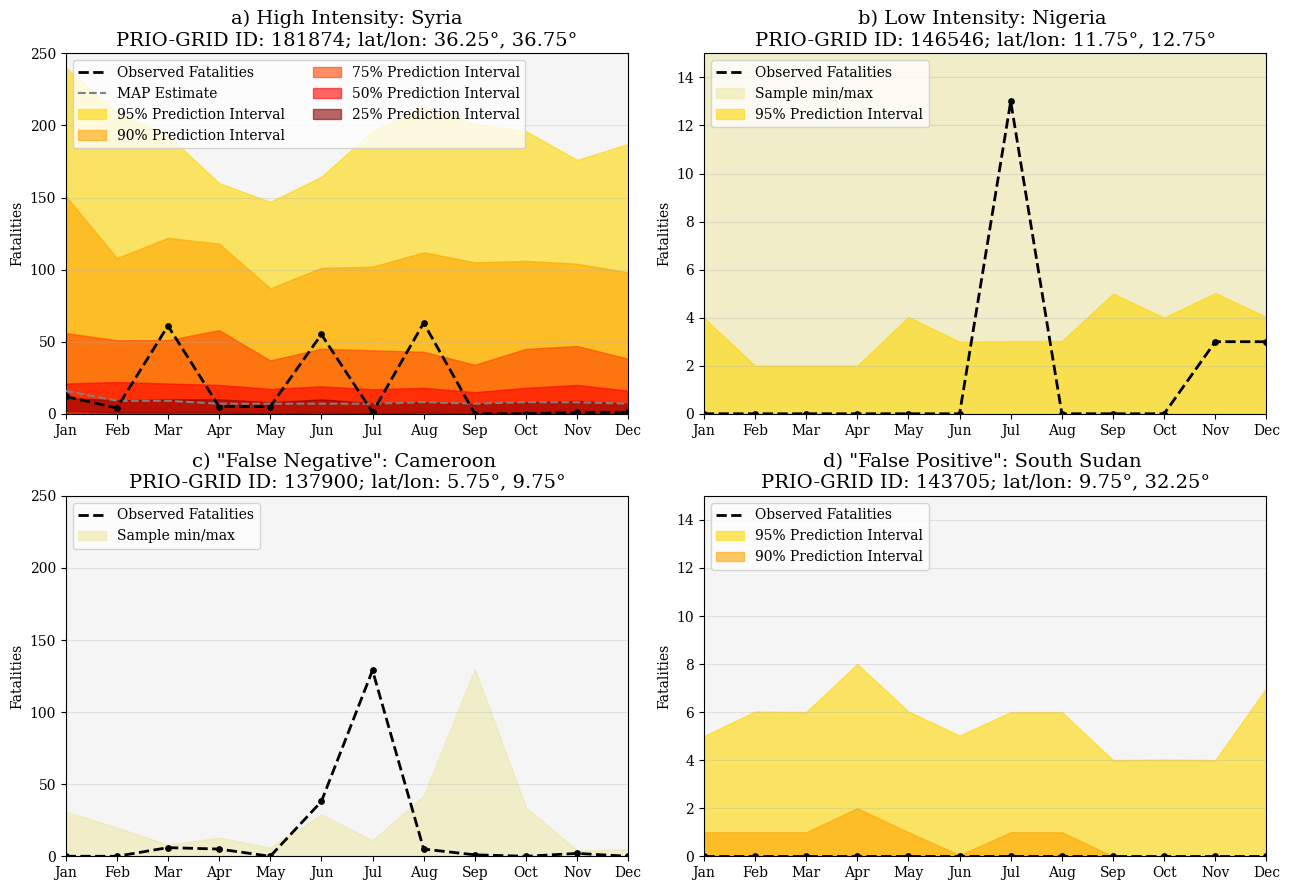

In [7]:
# High intensity: West of Aleppo --> Turkish Border - priogrid_gid 181874
# 10 months violence, mean fat: 17.33
pgid_syria = 181874 #(36.25, 36.75)
# Low intensity: Lake Chad region around Maiduguri, NGA - priogrid_gid 181874
# 3 months violence, mean fat: 1.58
pgid_lakechad = 146546 #(11.75, 12.75)
# Miss: inside Cameroon towards Nigeria-Cameroon border - Violence not predicted - priogrid_gid 137900
# 7 months violence, mean fat: 15.50
pgid_cameroon = 137900 #(5.75,9.75)
# "Miss": South Sudan (Upper Nile State) - Violence wrongly predicted (but violence not too far away in neighborhood) - priogrid_gid 143705
# zero violence
pgid_southsudan = 143705 #(3.75,32.255)


fig, axs = plt.subplots(2,2, figsize= (13, 9))
title_size = 14
plot_fats_cis(pgid_syria, axs[0][0], ["min", "99"])
lat, lon = pgid_to_latlon(pgid_syria) # only for 10% and 25% CI is the lower bound > 0
axs[0][0].set_ylim(0, 250)
axs[0][0].set_title(f"a) High Intensity: Syria\nPRIO-GRID ID: {pgid_syria}; lat/lon: {lat}°, {lon}°", size=title_size)
plot_fats_cis(pgid_lakechad, axs[0][1], ["99", "MAP"])
lat, lon = pgid_to_latlon(pgid_lakechad)
axs[0][1].set_ylim(0, 15)
axs[0][1].set_title(f"b) Low Intensity: Nigeria \nPRIO-GRID ID: {pgid_lakechad}; lat/lon: {lat}°, {lon}°", size=title_size)
plot_fats_cis(pgid_cameroon, axs[1][0], ["99", "MAP"])
lat, lon = pgid_to_latlon(pgid_cameroon)
axs[1][0].set_ylim(0, 250)
axs[1][0].set_title(f'c) "False Negative": Cameroon \nPRIO-GRID ID: {pgid_cameroon}; lat/lon: {lat}°, {lon}°', size=title_size)
plot_fats_cis(pgid_southsudan, axs[1][1], ["min", "99", "MAP"])
lat, lon = pgid_to_latlon(pgid_southsudan)
axs[1][1].set_ylim(0, 15)
axs[1][1].set_title(f'd) "False Positive": South Sudan \nPRIO-GRID ID: {pgid_southsudan}; lat/lon: {lat}°, {lon}°', size=title_size)
for ax in axs.flatten():
    ax.grid(which='major', alpha=.3, axis="y", zorder=1)
    ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.savefig("figures/Figure_2_individual_predictions.png", dpi=300)
plt.show()

Due to our hurdle combination, our distribution samples are heavily right-skewed, with prediction intervals generally starting at zero with the exception of high-intensity predictions, where smaller intervals may have higher lower bounds. Additionally, it should be noted that all predictions contain at least 1 non-zero draw due to the probabilistic classification predictions never being close enough to zero.

## Mean predictions over time
Lets take a quick look at mean predictions based on MAP estimates over time to see what the combination of the different timestep models does.

100%|██████████| 6/6 [16:58<00:00, 169.69s/it]


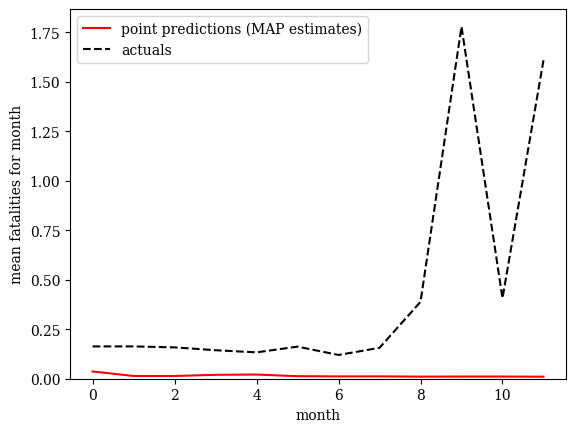

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.utils.data_prep import read_predictions, read_prio_actuals
from src.utils.evaluation import build_map_estimates

fp_views = 'data/views_data/'
fp_predictions = 'submissions/unibw_trees_global'
pmean_arrays = []
amean_arrays = []
for year in tqdm([2018, 2019, 2020, 2021, 2022, 2023]):
    predictions: xr.DataArray = read_predictions(fp_predictions, year)
    map_estimates = build_map_estimates(predictions)
    actuals: xr.DataArray = read_prio_actuals(fp_views, year)
    pmeans = map_estimates.mean("priogrid_gid")
    ameans = actuals.mean("priogrid_gid")
    pmean_arrays.append(pmeans.values)
    amean_arrays.append(ameans.values)

plt.plot(np.arange(0, 12, 1), np.stack(pmean_arrays).mean(axis=0), label="point predictions (MAP estimates)", color="red")
plt.plot(np.arange(0, 12, 1), np.stack(amean_arrays).mean(axis=0), "--", label="actuals", color="black")
plt.ylim(0, None)
plt.ylabel("mean fatalities for month")
plt.xlabel("month")
plt.legend()
plt.show()

While there is a bit of variance, there does not seem too much systematic bias although the MAP estimates are a bit lower than the actuals means (with spikes probably caused by outliers)

## Aggregate Scores
#### Table 1

How does the performance of our three main models compare to the benchmarks for the test windows based on various metrics?
This simply loads the pre-generated metrics, see `src/evaluation_pipeline.py` for how they are generated.

In [5]:
import os
import pandas as pd
from src.utils.data_prep import read_prio_actuals

fp_views = 'data/views_data/'
fp_metrics = f'evaluation/metrics'
test_windows = [2018, 2019, 2020, 2021, 2022, 2023]

df_means_yearly_test = pd.DataFrame(index=pd.Index(test_windows, name='window'), columns=['fat_count', 'dummy_count'])
for year in test_windows:
    actuals = read_prio_actuals(fp_views, year, as_xarray=False)
    # Trends in metrics correlate with mean fatalities/number of
    df_means_yearly_test.at[year, 'fat_count'] = actuals.ged_sb.sum()
    df_means_yearly_test.at[year, 'nonzero_count'] = (actuals.ged_sb > 0).sum()

dfs = []
for year in test_windows:
    fp_metrics_window = os.path.join(fp_metrics, f'metrics_benchmarks_full_{year}.csv')
    df = pd.read_csv(fp_metrics_window, index_col=0)
    df['window'] = year
    dfs.append(df.set_index('window', append=True))

df_metrics = pd.concat(dfs).reorder_levels([1,0]).sort_index()
df_metrics


global         local  global-local  conflictology_n  \
window metrics                                                              
2018   crps         0.130027      0.137576      0.132371         0.147324   
       ign          0.068100      0.082361      0.069098         0.177025   
       mae          0.148678      0.151621      0.153833         0.158321   
       mis          2.164582      2.454598      2.226648         3.062174   
       mse         62.395728     59.706820     61.681662        64.951303   
2019   crps         0.100957      0.103962      0.101202         0.106776   
       ign          0.066369      0.080486      0.066811         0.175478   
       mae          0.115256      0.115605      0.117251         0.120417   
       mis          1.559936      1.823876      1.602342         1.878593   
       mse         16.665128     16.515084     16.603420        16.717455   
2020   crps         0.118001      0.122074      0.118156         0.122955   
       ign          0.074347      0.087248      0.074249         0.181817   
       mae          0.131109      0.133804      0.131458         0.133359   
       mis          1.901126      2.205414      1.900115         2.115173   
       mse         16.811670     16.708302     16.795570        16.931884   
2021   crps         0.924558      0.929297      0.924416         0.927942   
       ign          0.084273      0.096421      0.084270         0.189316   
       mae          0.938285      0.940484      0.937694         0.941381   
       mis         17.978819     18.349596     17.978511        18.105639   
       mse      81844.479780  81844.539404  81844.158263     81844.540071   
2022   crps         1.127449      1.128890      1.126355         1.131095   
       ign          0.083375      0.095073      0.083205         0.189609   
       mae          1.139614      1.140230      1.140319         1.144184   
       mis         22.246654     22.455022     22.235311        22.475425   
       mse      98555.711035  98555.400718  98553.678598     98547.876793   
2023   crps         0.214737      0.220734      0.217610         0.249927   
       ign          0.086303      0.098787      0.086688         0.192226   
       mae          0.227511      0.256490      0.244394         0.233835   
       mis          3.980662      4.287910      4.103594         4.033371   
       mse        163.264582    163.169254    163.521726       163.392455   

                        last          zero  conflictology      boot_240  
window metrics                                                           
2018   crps     3.860120e-01      0.144413       0.191881      0.144348  
       ign      1.177387e-01      0.091636       0.858874      0.092515  
       mae      4.019896e-01      0.144413       0.223195      0.144413  
       mis      7.148820e+00      2.888253       2.834462      2.888253  
       mse      1.694468e+02     65.815338      86.967868     65.815338  
2019   crps     1.441701e-01      0.115446       0.118448      0.115406  
       ign      1.050151e-01      0.094423       0.856085      0.095078  
       mae      1.515256e-01      0.115446       0.127473      0.115453  
       mis      2.616556e+00      2.308924       1.888665      2.308924  
       mse      1.822431e+01     17.238787      17.444317     17.238794  
2020   crps     1.646080e-01      0.131871       0.127484      0.131727  
       ign      1.162691e-01      0.107665       0.859889      0.107154  
       mae      1.724701e-01      0.131871       0.136473      0.131871  
       mis      2.992770e+00      2.637427       2.073143      2.637427  
       mse      1.874659e+01     17.217620      16.547381     17.217620  
2021   crps     9.703294e-01      0.939804       0.930226      0.939574  
       ign      1.285833e-01      0.118816       0.864825      0.117519  
       mae      9.793160e-01      0.939804       0.942601      0.939804  
       mis      1.908006e+01     18.796084      17.869995     18.796084  
   

For individual test windows, e.g. 2018:

In [57]:
df_metrics.loc[2018][["global", "local", "global-local", "zero", "last", "conflictology", "conflictology_n", "boot_240"]].T

metrics,crps,ign,mae,mis,mse
global,0.130027,0.068100,0.148678,2.164582,62.395728
local,0.137576,0.082361,0.151621,2.454598,59.706820
global-local,0.132371,0.069098,0.153833,2.226648,61.681662
zero,0.144413,0.091636,0.144413,2.888253,65.815338
last,0.386012,0.117739,0.401990,7.148820,169.446752
conflictology,0.191881,0.858874,0.223195,2.834462,86.967868
conflictology_n,0.147324,0.177025,0.158321,3.062174,64.951303
boot_240,0.144348,0.092515,0.144413,2.888253,65.815338


### Table 2

Quick look at score correlations:

In [15]:
dfs = []
for metric in ['crps', 'ign', 'mis', 'mse', 'mae']:
    df = df_means_yearly_test.copy()
    for col in df_metrics.columns:
        df[col] = df_metrics.loc[(slice(None), metric), col].to_list()
    df['metric'] = metric
    df = df.set_index('metric', append=True)
    dfs.append(df)
df_cor = pd.concat(dfs, axis=0).sort_index()
for metric in ['crps', 'ign', 'mis']:
    print(metric.upper(), '\n', df_cor.loc[(slice(2018, 2023), metric), :].corr().round(5).loc[['fat_count', 'nonzero_count'], slice('global',None)])

CRPS 
                 global    local  global-local  conflictology_n     last  \
fat_count      0.99998  0.99998       0.99997          0.99957 -0.10729   
nonzero_count  0.66297  0.66317       0.66365          0.67415  0.54045   

                  zero  conflictology  boot_240  
fat_count      1.00000        0.96532   1.00000  
nonzero_count  0.66025        0.78414   0.66016  
IGN 
                 global    local  global-local  conflictology_n     last  \
fat_count      0.64328  0.61527       0.63004          0.62442  0.52381   
nonzero_count  0.98190  0.97257       0.97333          0.97840  0.84532   

                  zero  conflictology  boot_240  
fat_count      0.66025        0.60015   0.65347  
nonzero_count  1.00000        0.92618   0.99991  
MIS 
                 global    local  global-local  conflictology_n     last  \
fat_count      0.99989  0.99993       0.99984          0.99951 -0.10759   
nonzero_count  0.66577  0.66706       0.66732          0.64671  0.54067   

   

We have near-perfect correlation between CRPS/MIS and Fatalitiy counts and extremly high correlation between IGN and non-zero pgms over time

This can be explained with the aggregation function over multiple predictions, e.g. for CRPS:

$CRPS_N=\frac{1}{N} \sum_{n=1}^{N} CRPS_n = \frac{\sum_{n=1}^{N} CRPS_n}{N}$

Assuming a predictor will mostly predict all-zero samples for zero violence, for these cases the individual CRPS score is zero. This increases the denominator without affecting the nominator, reducing the possible ranges of the score.

## Simulation Experiment CRPS
The scores are pretty close together... is any of the models really better? How much is the CRPS, our main metric, able to change for our level of zero-inflatedness. We design an experiment with simulated data, varying the quality of predictions in a controlled way to explore this.

We use Kernel density estimation to get the distribution of non-zero fatalities and simulate realistic data. Our simulated “perfect” predictions are created by drawing prediction samples with size N=1000 from a poisson distribution, setting 𝜆 to the simulated actual value. 

We introduce errors to our predictions in two ways:
- we vary the “accuracy” by replacing a share of the non-zero prediction samples with all-zero samples
- we add random noise to all non-zero actuals before drawing the samples, i.e. randomly shift the center of our predictive distributions away from the actual value.

### Setup

share of non-zero priogrid-months: 0.0049654528892937285


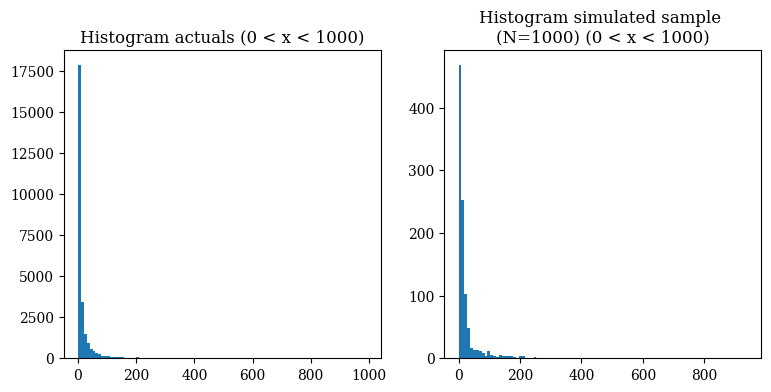

In [5]:
# Load the actual data and have a look at the distribution
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
import xarray as xr
import xskillscore as xs

from src.utils.data_prep import read_prio_training_data

fp_views = 'data/views_data/' # path to views data
df, _ = read_prio_training_data(fp_views, 2024) # full data for final predictions - only used to estimate the distribution
df = df['ged_sb']
print("share of non-zero priogrid-months:", len(df[df > 0])/len(df))

# estimate the distribution of non-zero - based on 1000 as upper boundary
kde = gaussian_kde(df[(df<1000) & (df > 0)].values)
def create_sample(size:int = 1000) -> np.ndarray:
    sample = kde.resample(size, seed=0).squeeze()
    # mirror across boundary
    sample[sample<0] = sample[sample<0] * -1
    # we dont need to round since we draw from a poisson distribution afterwards
    return sample

# doublecheck
fig, axs = plt.subplots(1,2, figsize=(9,4))
axs[0].hist(df[(df<1000) & (df > 0)], bins=100)
axs[1].hist(create_sample(), bins=100)
axs[0].set_title('Histogram actuals (0 < x < 1000)')
axs[1].set_title('Histogram simulated sample \n(N=1000) (0 < x < 1000)')
plt.show()

draws=1000
percentages = np.arange(0.02, 0.21, 0.02).round(2)

def simulate_actuals(p_nonzero:float, n_predictions:int) -> np.ndarray:
    """Creates simulated actuals based on the observed distribution for non-zero values
    at different degrees of zero-inflatedness.
    """       

    rng = np.random.default_rng(1128678679834231123412453456723123523423)
    n_sample = round(p_nonzero*n_predictions)
    base_sample = create_sample(n_sample)
    # fatalities can only be integers
    base_sample = np.where(base_sample < 0.5, 1, base_sample.round())
    
    simulated_actuals = np.pad(base_sample, (0, n_predictions - len(base_sample)))
    # shuffle sample so we don't have to worry about order in randomly generating stuff
    rng.shuffle(simulated_actuals)
    
    return simulated_actuals


def predictions_accuracy_noise(actuals: xr.DataArray, accuracy: str|float = 1, noise: float = 0, distribution: str = "poisson", std:float = None, replace_negative:bool = True, noise_basis:int=50) -> xr.DataArray:
    """ Creates simulated distributional predictions at different levels of "accuracy" and with 
    varying "noise", depending on the args.
    """
    rng = np.random.default_rng(12311223478867976805634564678931212313523423)
    # do the accuracy adjustment
    if accuracy != 1:
        # for this not to have unrealistically huge impacts, lets just apply this to predictions with actuals by simply
        # replacing with zero. This gets turned into an all-zero sample by the poisson
        mask = rng.uniform(size=len(actuals)) > accuracy
        point_predictions = xr.where(mask, 0, actuals)
    else:
        point_predictions = actuals

    # add noise
    point_predictions = point_predictions + (rng.uniform(-1, 1, size=point_predictions.shape) * noise_basis * noise)
    point_predictions = xr.where((point_predictions < 0) | (actuals == 0), 0, point_predictions) # no negative predictions

    # simulate draws and make xarray
    if distribution == "poisson":
        predictions = np.array([rng.poisson(val, draws) for val in point_predictions.values])
    elif distribution == "normal":
        if std is None:
            std = float(actuals.std())
        predictions = np.array([rng.normal(val, std, draws) if val != 0 else np.zeros(1000) for val in point_predictions.values])
        if replace_negative:
            # no negative predictions
            predictions[predictions < 0] == 0
        
    da_predictions = xr.DataArray(
        data = predictions,
        coords={
            'id': range(len(actuals)),
            'draw': range(draws)
        },
        name='predictions'
    )
    return da_predictions

### CRPS Variance and Vizualization
#### Figure 3

We vary the accuracy and add some noise to the predictions before drawing a poisson sample and calculating crps. We only do this for non-zero predictions (zero actuals are always paired with all-zero predictions), so the CRPS values in this test are slighly better than the actual CRPS scores above.

In [6]:
size = 13110 * 12 # 131000 grid cells x 12 months - corresponds to a year
simulated_actuals_005 = xr.DataArray(data=simulate_actuals(0.005, 13110 * 12), coords={"id":range(size)})

# how do classification accuracy and worse (randomly shifted before drawing poisson samples) prediction samples affect the score?
accuracy = np.linspace(0,1,11).round(1)
noise = np.linspace(0,1,11).round(1)
df_simulated = pd.DataFrame(index=accuracy, columns=noise)
df_simulated.index.name = 'accuracy'
df_simulated.columns.name = 'noise'
for a in accuracy:
    if a == 0:
        df_simulated.loc[a] = np.nan
        continue
    for n in noise:
        # accuracy == 0 would be all-zero in this setup
        df_simulated.at[a, n] = float(xs.crps_ensemble(simulated_actuals_005, predictions_accuracy_noise(simulated_actuals_005, accuracy=a, noise=n, noise_basis=50), member_dim='draw').values)

df_simulated

noise,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
accuracy,,,,,,,,,,,
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.1,0.096964,0.09122,0.089029,0.088838,0.089973,0.091908,0.094477,0.097347,0.100612,0.10417,0.107864
0.2,0.088296,0.083809,0.082776,0.08351,0.085355,0.08796,0.091043,0.094562,0.098285,0.102269,0.106466
0.3,0.080745,0.077426,0.077633,0.079403,0.082035,0.0853,0.088982,0.09295,0.097194,0.101545,0.106038
0.4,0.068383,0.065942,0.067124,0.069757,0.073161,0.077099,0.081382,0.085907,0.090588,0.095325,0.100308
0.5,0.054552,0.053388,0.055792,0.05943,0.063726,0.068314,0.073264,0.078255,0.083468,0.088676,0.093978
0.6,0.044302,0.044413,0.048158,0.052924,0.058097,0.063524,0.069107,0.074888,0.080557,0.086439,0.092226
0.7,0.035031,0.036066,0.040718,0.046354,0.05223,0.058176,0.064188,0.070265,0.076396,0.082581,0.088568
0.8,0.024936,0.027128,0.033112,0.039891,0.0467,0.053407,0.060065,0.066691,0.073204,0.079812,0.086208


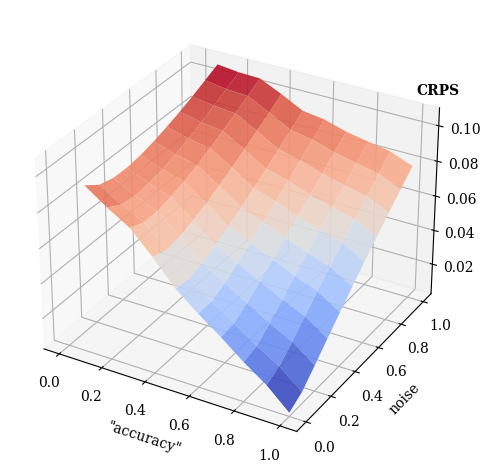

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
X, Y = np.meshgrid(accuracy[::-1], noise)
surf = ax.plot_surface(X, Y, df_simulated.sort_index(ascending=False).values.T, cmap="coolwarm", linewidth=0, antialiased=True, alpha=.9)
ax.set_xlabel('"accuracy"')
ax.set_ylabel("noise")
ax.text2D(0.072, 0.055, "CRPS", weight="bold")
# ax.set_title('CRPS for simulated data at different\nlevels of non-zero "accuracy" and random noise', size=11)
plt.tight_layout()
plt.savefig("figures/Figure_3_CRPS_variance.png", dpi=300)
plt.show()


Classification accuracy has a greater impact on the CRPS at low levels of noise. The impact of noise is very linear/strong at high accuracy and lower at low accuracy levels. While this simulation results in overall slighly better scores than we observe in our models, we can see that e.g. a relatively strong improvement in accuracy by 10 percentage points results in a CRPS improvement of roughly 0.01 in the best-case scenario (no noise). Given that we see CRPS improvements of a similar size over benchmarks in the test windows, this raises our confidence in out model's performance.

Robustness check - increasing the noise max value

In [8]:
# robustness check: noise 100
df_simulated3 = pd.DataFrame(index=accuracy, columns=noise)
df_simulated3.index.name = 'accuracy'
df_simulated3.columns.name = 'noise'
for a in accuracy:
    if a == 0:
        df_simulated3.loc[a] = np.nan
        continue
    for n in noise:
        # accuracy == 0 would be all-zero in this setup
        df_simulated3.at[a, n] = float(xs.crps_ensemble(simulated_actuals_005, predictions_accuracy_noise(simulated_actuals_005, accuracy=a, noise=n, noise_basis=100), member_dim='draw').values)

df_simulated3

noise,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
accuracy,,,,,,,,,,,
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.1,0.096964,0.089029,0.089973,0.094477,0.100612,0.107864,0.115921,0.124504,0.133648,0.143096,0.152882
0.2,0.088296,0.082776,0.085355,0.091043,0.098285,0.106466,0.115218,0.12441,0.134083,0.144088,0.154422
0.3,0.080745,0.077633,0.082035,0.088982,0.097194,0.106038,0.115353,0.125001,0.1351,0.145385,0.155933
0.4,0.068383,0.067124,0.073161,0.081382,0.090588,0.100308,0.110237,0.120451,0.130961,0.141766,0.152747
0.5,0.054552,0.055792,0.063726,0.073264,0.083468,0.093978,0.104638,0.115392,0.126393,0.137619,0.148978
0.6,0.044302,0.048158,0.058097,0.069107,0.080557,0.092226,0.103793,0.115347,0.126995,0.138629,0.150452
0.7,0.035031,0.040718,0.05223,0.064188,0.076396,0.088568,0.100682,0.112652,0.124752,0.136727,0.148838
0.8,0.024936,0.033112,0.0467,0.060065,0.073204,0.086208,0.098876,0.111351,0.123915,0.136478,0.148908


The more we increase the multiplier, the more the effect of noise overwhelms the scores, with "accuracy" making less and less of a difference.

## Ranking-Based Evaluation using Countries
Closer to real world application: Rank performance for each country compare models by comparing the mean rank across all countries. For simplicity's sake, we only do this for our best, i.e. global model

### Setup
This can take a few hours if not in storage.

Match priogrids to clusters and countries

In [4]:
from functools import partial
import pickle

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import pyproj
from tqdm import tqdm
from shapely.geometry import box
import xarray as xr

from evaluation_pipeline import evaluation_pipeline
from src.utils.data_prep import read_prio_actuals, read_predictions, read_benchmarks
from src.utils.conversion import pgid_to_latlon

tqdm.pandas()
fp_views = 'data/views_data/'
fp_metrics = f'evaluation/metrics'
test_windows = [2018, 2019, 2020, 2021, 2022, 2023]

def assign_country(pgid, s=.5):
    lat, lon = pgid_to_latlon(pgid)
    geometry = box(lon-s/2, lat-s/2, lon+s/2, lat+s/2)
    try:
        clipped = countries.clip(geometry)
    except Exception as e: # should not happen anymore
        print(pgid, e)
        return 'exception'
    if clipped.empty:  # this means if not touching any geometry
        return 'not_assigned'
    elif len(clipped)==1:
        return clipped.iloc[0].shapeGroup
    else:
        # reprojecting to albers equal area equidistant projection for area calculations
        lat_1 = lat - s/3
        lat_2 = lat + s/3
        aea_proj = pyproj.crs.CRS(
            f'+proj=aea +ellps="WGS84" +lat_1={lat_1} +lat_2={lat_2} +lat_0={lat} +lon_0={lon} +units=m')
        # get area
        clipped['area_size'] = clipped.to_crs(aea_proj).area
        # get index of the largest area in cell and assign its name to grid
        i = clipped.area_size.idxmax()
        return countries.loc[i]['shapeGroup']

with open('data/clusters_dict.pkl', 'rb') as f:
    df_clusters = pickle.load(f)['hdbscan']

# geoboundaries for country matching
countries = gpd.read_file('data/geoBoundariesCGAZ_ADM0.gpkg', crs='4326')
countries.geometry = countries.geometry.make_valid() # takes a bit but avoids annoying errors
# match grid with countries - majority rule
# this leaves some grid cells unassigned, which are fixed below
df_clusters['iso3'] = df_clusters.reset_index().priogrid_gid.progress_apply(assign_country).to_list()
df_clusters.loc[df_clusters.iso3 == 'not_assigned', "iso3"] = ["MDG", "NAM", "MDG", "MDG", "SAU", "EGY", "LBY"]
df_clusters

100%|██████████| 13110/13110 [05:02<00:00, 43.32it/s]


,ged_sb,lat,lon,cluster,iso3
priogrid_gid,,,,,
62356,0.0,-46.75,37.75,3,ZAF
79599,0.0,-34.75,19.25,3,ZAF
79600,0.0,-34.75,19.75,3,ZAF
79601,0.0,-34.75,20.25,3,ZAF
80317,0.0,-34.25,18.25,3,ZAF
...,...,...,...,...,...
190496,0.0,42.25,27.75,0,BGR
190507,0.0,42.25,33.25,0,TUR
190508,0.0,42.25,33.75,0,TUR


Calculate metrics for individual clusters and countries. (The print output here isnt great since it calls the evaluation pipeline in a loop.)

In [48]:
# year unused but needed for compatibility reasons
def load_evaluation_data(year: int, observed: xr.DataArray, predictions: xr.DataArray, views_benchmarks: dict[str, xr.DataArray], df_clusters: pd.DataFrame,
                         cluster_col: str, cluster: int):
    pgids = list(df_clusters[df_clusters[cluster_col]==cluster].index)
    observed = observed.sel(priogrid_gid=pgids)
    predictions = predictions.sel(priogrid_gid=pgids)
    predictions_dict = {'global': predictions}
    views_benchmarks = {bench: data.sel(priogrid_gid=pgids) for bench, data in views_benchmarks.items()}
    predictions_dict = {**predictions_dict, **views_benchmarks}
    print('data filtered for cluster', cluster)
    return observed, predictions_dict

try:
    with open("evaluation/country_metrics.pkl", "rb") as f:
        metrics_dict = pickle.load(f)

except FileNotFoundError:
    metrics_dict = {}
    for year in test_windows:
        metrics_dict[year] = {}
        print('load predictions...')
        observed = read_prio_actuals(fp_views, year=year)
        predictions = read_predictions(f'submissions/unibw_trees_global', year, 'pgm')
        print('load benchmarks...')
        benchmarks = ['conflictology_n', 'last', 'zero', 'conflictology', 'boot_240']
        views_benchmarks = {bench: read_benchmarks(fp_views, year, bench) for bench in benchmarks}

        local_clusters = list(df_clusters.cluster.unique())
        iso3_clusters = list(df_clusters.iso3.unique())
        # combine and store local clusters
        dfs = []
        for cluster in local_clusters:
            load_data_func = partial(load_evaluation_data, df_clusters=df_clusters, cluster=cluster, cluster_col='cluster', observed=observed, predictions=predictions,
                                     views_benchmarks=views_benchmarks)
            df_metrics_cluster = evaluation_pipeline(year, load_data_func, fp_out = '', save=False, bootstrap=False, regenerate_metrics=True, return_results=True)
            dfs.append(df_metrics_cluster.rename(columns={col: f'{col}_{cluster}' for col in df_metrics_cluster.columns}))
        df_metrics_clusters_local = pd.concat(dfs, axis=1)
        metrics_dict[year]['local_clusters'] = df_metrics_clusters_local
        # evaluate for iso3 clusters
        dfs = []
        for cluster in iso3_clusters:
            load_data_func = partial(load_evaluation_data, df_clusters=df_clusters, cluster=cluster, cluster_col='iso3', observed=observed, predictions=predictions,
                                    views_benchmarks=views_benchmarks)
            df_metrics_cluster = evaluation_pipeline(year, load_data_func, fp_out = '', save=False, bootstrap=False, regenerate_metrics=True, return_results=True)
            dfs.append(df_metrics_cluster.rename(columns={col: f'{col}_{cluster}' for col in df_metrics_cluster.columns}))
        df_metrics_clusters_iso3 = pd.concat(dfs, axis=1)
        metrics_dict[year]['iso3_clusters'] = df_metrics_clusters_iso3

    with open("evaluation/country_metrics.pkl", "wb") as f:
        pickle.dump(metrics_dict, f)



load predictions...
load benchmarks...
##### window 2018 #####
Loading predictions and creating benchmarks...
data filtered for cluster 3
Calculating prediction and benchmark metrics...
##### window 2018 #####
Loading predictions and creating benchmarks...
data filtered for cluster 5
Calculating prediction and benchmark metrics...
##### window 2018 #####
Loading predictions and creating benchmarks...
data filtered for cluster 4
Calculating prediction and benchmark metrics...
##### window 2018 #####
Loading predictions and creating benchmarks...
data filtered for cluster 2
Calculating prediction and benchmark metrics...
##### window 2018 #####
Loading predictions and creating benchmarks...
data filtered for cluster 0
Calculating prediction and benchmark metrics...
##### window 2018 #####
Loading predictions and creating benchmarks...
data filtered for cluster 1
Calculating prediction and benchmark metrics...
##### window 2018 #####
Loading predictions and creating benchmarks...
data fil

### Visualization: Model-wide vs. Country Scores
#### Figure 4

Reload the aggregate metrics and compare them to the country metrics. We see large variance, since this essentially varies the zero-inflatedness for each individual unit, so scores across countries cannot be compared directly.


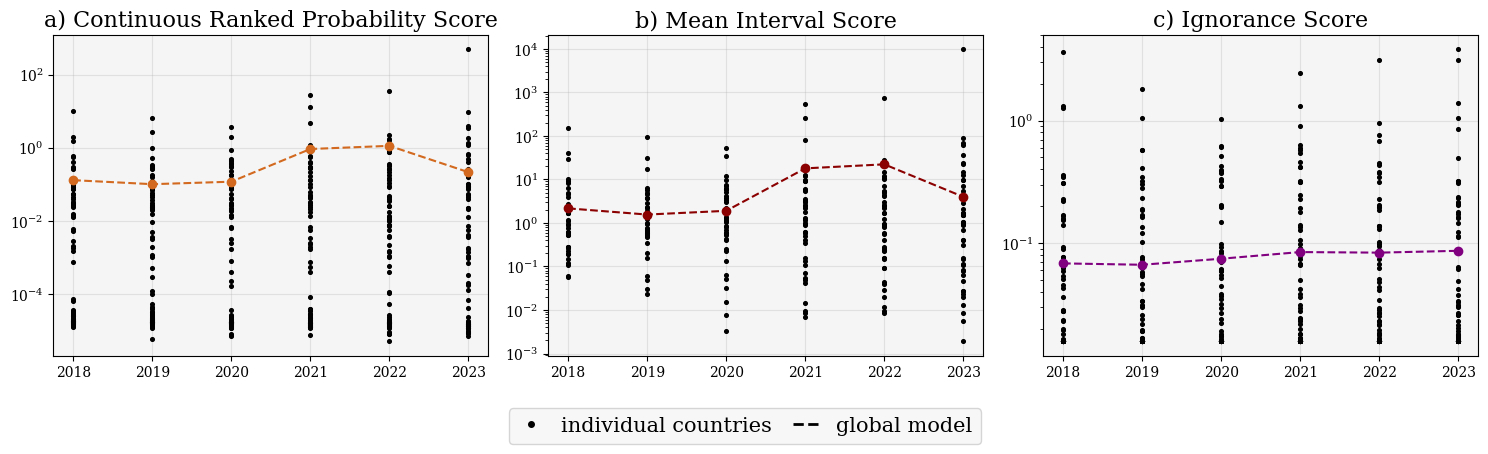

In [49]:
dfs = []
for year in test_windows:
    fp_metrics_window = os.path.join(fp_metrics, f'metrics_benchmarks_full_{year}.csv')
    df = pd.read_csv(fp_metrics_window, index_col=0)
    df['window'] = year
    dfs.append(df.set_index('window', append=True))

df_metrics = pd.concat(dfs).reorder_levels([1,0]).sort_index()


fig, axs = plt.subplots(1, 3, figsize=(15,4))
titles = ['a) Continuous Ranked Probability Score', 'b) Mean Interval Score', 'c) Ignorance Score']
metrics = ['crps', 'mis', 'ign']
size = 16
colors = ["chocolate", 'darkred', 'purple']
years = test_windows
for i, ax in enumerate(axs):
    scores = df_metrics.xs(metrics[i], level="metrics")['global']

    line, = ax.plot(scores, ls="dashed", zorder=10, color=colors[i])
    ax.scatter(years, scores.values, zorder=10, color=colors[i])


    # for year in test_windows:
    #     ax.scatter(x=[year for i in range(len(df_clusters['cluster'].unique()))], y=metrics_dict[year]['local_clusters'].loc[metrics[i]], s=5, c='black', zorder=5)
    for j, year in enumerate(test_windows):
        metrics_countries = metrics_dict[year]['iso3_clusters'].loc[metrics[i], [c for c in metrics_dict[year]['iso3_clusters'].columns if 'global_' in c]]
        ax.scatter(x=[year for i in range(len(metrics_countries))], y=metrics_countries, s=7, c='black', zorder=5)

    ax.set_yscale('log')
    ax.set_title(titles[i], size=size)


for ax in axs.flatten():
    ax.set_xticks(test_windows)
    ax.grid(which='major', alpha=.3)
    ax.set_facecolor('whitesmoke')

# legend
iso3_handle = Line2D(
    [0], [0], 
    marker='o', 
    color='black', 
    linestyle='None', 
    markersize=4, 
    label='individual countries'
)

global_handle = Line2D(
    [0], [0], 
    linestyle='--', 
    color='black', 
    linewidth=2, 
    label='global model'
)

fig.legend(handles=[iso3_handle, global_handle], loc='lower center', ncols=2, fontsize=size-1, columnspacing=1, handlelength=1.3,
                 bbox_to_anchor=(0.5, -0.15), facecolor='whitesmoke')

plt.tight_layout()
plt.savefig(f'figures/Figure_4_country_variance_v_global.png', dpi=300, bbox_inches="tight")
plt.show()

### Ranking-Based Performance
#### Table 3

Lets therefore compare how the model performs compared to the benchmarks across the different countries in a ranking-based approach.

In [50]:
import pandas as pd

from src.utils.data_prep import read_prio_actuals

fp_views = 'data/views_data/' # path to views data
test_windows = [2018, 2019, 2020, 2021, 2022, 2023]
models = ['global', 'zero', 'last', 'conflictology', 'conflictology_n', 'boot_240']
metrics = ['crps', 'mis', 'ign']

index = pd.MultiIndex.from_product([test_windows, metrics, models], names=["year", "metric", "model"])
df_mean_rank = pd.DataFrame(index=index, columns=['mean_rank', 'mean_rank_nonzero'])
always_nonzero = df_clusters.iso3.unique()

for year in test_windows:
    actuals = read_prio_actuals(fp_views, year)
    for model in models:
        for metric in metrics:
            metrics_countries = metrics_dict[year]['iso3_clusters'].loc[metric]
            df_rank = pd.DataFrame(index=df_clusters.iso3.unique(), columns=['rank', 'mean_fatalities'])
            for iso3 in df_clusters.iso3.unique():
                df_iso3_model = metrics_countries.loc[[c for c in metrics_countries.index if iso3 in c]].to_frame().reset_index().rename(columns={'index': 'model'})
                df_iso3_model['model'] = df_iso3_model['model'].apply(lambda x: x.removesuffix(f'_{iso3}'))
                df_iso3_model['rank'] = df_iso3_model[metric].rank(method="min")
                df_rank.at[iso3, 'rank'] = df_iso3_model[df_iso3_model.model==model]["rank"].item()

                pgids = list(df_clusters[df_clusters.iso3==iso3].index)
                df_rank.at[iso3, 'mean_fatalities'] = float(actuals.sel(priogrid_gid=pgids).mean())
                if df_rank.at[iso3, 'mean_fatalities'] != 0:
                    always_nonzero = [c for c in always_nonzero if c != iso3]

            df_mean_rank.at[(year, metric, model), 'mean_rank'] = df_rank['rank'].mean()
            df_mean_rank.at[(year, metric, model), 'mean_rank_nonzero'] = df_rank[df_rank.mean_fatalities != 0]['rank'].mean()
            # df_mean_rank.at[(year, metric, model), 'all_zero_iso3s'] = (df_rank['mean_fatalities'] == 0).sum()

for metric in metrics:
    print(metric.upper(), ":\n", df_mean_rank.groupby(["metric", "model"]).mean().loc[metric].sort_values("mean_rank_nonzero"))


CRPS :
                 mean_rank mean_rank_nonzero
model                                      
global                3.7           2.43001
conflictology_n  2.322917          2.833526
zero              2.08125          3.244156
conflictology    2.379167          3.545279
boot_240         4.854167          3.907881
last             2.595833          4.240827
MIS :
                 mean_rank mean_rank_nonzero
model                                      
global           1.939583          2.583919
boot_240           1.8125          2.684002
zero               1.8125          2.684002
conflictology_n  2.120833          2.841209
conflictology    2.070833          2.900808
last               2.2375          3.514494
IGN :
                 mean_rank mean_rank_nonzero
model                                      
global           2.327083          1.552158
zero             1.816667          2.695433
boot_240             3.55          3.142202
last             2.122917          3.277815
conflictol

When comparing the average rank in the metrics across each country, our best ('global') model not does have the highest average rank on any metric. However, when only looking at countries experiencing violence, our model has a higher mean rank (CRPS: .4 ranks, MIS: .1 ranks, IGN: 1.15 ranks out of 6), leading to the overall better score. This can be explained by the model always accounting for a small possibility of violence even in peaceful cases.